# Projekt PRiAD Natalia Biernacka, Anton Libik
### Wybrany zbiór danych: Titanic Survival Prediction Dataset


Import niezbędnych pakietów

In [207]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

pd.options.display.float_format = "{:.2f}".format 

In [208]:
import kagglehub
import os

# Download latest version
path = kagglehub.dataset_download("yasserh/titanic-dataset") 
print("Path to dataset files:", path)

file_path = os.path.join(path, 'Titanic-Dataset.csv')
dane = pd.read_csv(file_path)
dane.head()

Path to dataset files: C:\Users\Anton\.cache\kagglehub\datasets\yasserh\titanic-dataset\versions\1


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.00,1,0,A/5 21171,7.25,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.00,1,0,PC 17599,71.28,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.00,0,0,STON/O2. 3101282,7.92,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.00,1,0,113803,53.10,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.00,0,0,373450,8.05,NaN,S


### Analiza eksploracyjna

1) Wyznaczamy liczbę obiektów, liczbę atrybutów. Usuwamy kolumny PassengetId, Ticket i Name - nie są one potrzebne dla dalszej analizy.


In [209]:
# liczba obiektów
print("Liczba obiektów:", dane.shape[0])

# liczba atrybutów
print("Liczba atrybutow:", dane.shape[1])

# usuwanie kolumny PassengerId i Name
dane.drop(columns=['PassengerId'], inplace=True)
dane.drop(columns=['Name'], inplace=True)
dane.drop(columns=['Ticket'], inplace=True)

Liczba obiektów: 891
Liczba atrybutow: 12


2. Liczba obiektów, reprezentujących pasażerów, które przeżyli (atrybut survived ma 1) i które nie (survived = 0)

In [210]:
survivedDF = dane[dane.Survived == 1]

notSurvivedDF = dane[dane.Survived == 0]

print("Liczba pasażerów, które przeżyły: ", survivedDF.shape[0])
print("Liczba pasażerów, które nie przeżyły: ", notSurvivedDF.shape[0])

procent = survivedDF.shape[0] / dane.shape[0] * 100
print("Ile procent przeżyło: ", round(procent, 2), "%")

Liczba pasażerów, które przeżyły:  342
Liczba pasażerów, które nie przeżyły:  549
Ile procent przeżyło:  38.38 %


3. Liczba brakujących danych w poszczególnych kolumnach

In [211]:
dane.isnull().sum()

Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Cabin       687
Embarked      2
dtype: int64

4. Usuwamy kolumnę "Cabin", ponieważ zawiera dużą liczbę brakujących danyh i będzie przeszkadać analizie. Zamiast brakujących danych w kolumnie "Age" wstawiamy dane średniego wieku.

In [212]:
# usuwamy kolumnę Cabin
dane.drop(columns=['Cabin'], inplace=True)

# wstawiamy średni wiek zamiast brakujących danych w kolumnie Age
dane['Age'] = dane['Age'].fillna(dane['Age'].median())

# sprawdzamy liczbę brakujących danych 
dane.isnull().sum()

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    2
dtype: int64

5. Usuwamy pozostałe brakujące dane

In [213]:
dane = dane.dropna()

dane.isnull().sum()

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

6. Zbiór został przygotowany do analizy ekploracyjnej, ostateczna liczba obiektów i atrybutów:

In [214]:
# liczba obiektów
print("Liczba obiektów:", dane.shape[0])

# liczba atrybutów
print("Liczba atrybutow:", dane.shape[1])

Liczba obiektów: 889
Liczba atrybutow: 8


##### Analiza zmienności atrybutów bez odniesienia do przeżycia

       Survived  Pclass    Age  SibSp  Parch   Fare
count    889.00  889.00 889.00 889.00 889.00 889.00
mean       0.38    2.31  29.32   0.52   0.38  32.10
std        0.49    0.83  12.98   1.10   0.81  49.70
min        0.00    1.00   0.42   0.00   0.00   0.00
25%        0.00    2.00  22.00   0.00   0.00   7.90
50%        0.00    3.00  28.00   0.00   0.00  14.45
75%        1.00    3.00  35.00   1.00   0.00  31.00
max        1.00    3.00  80.00   8.00   6.00 512.33


<Axes: xlabel='Embarked', ylabel='Count'>

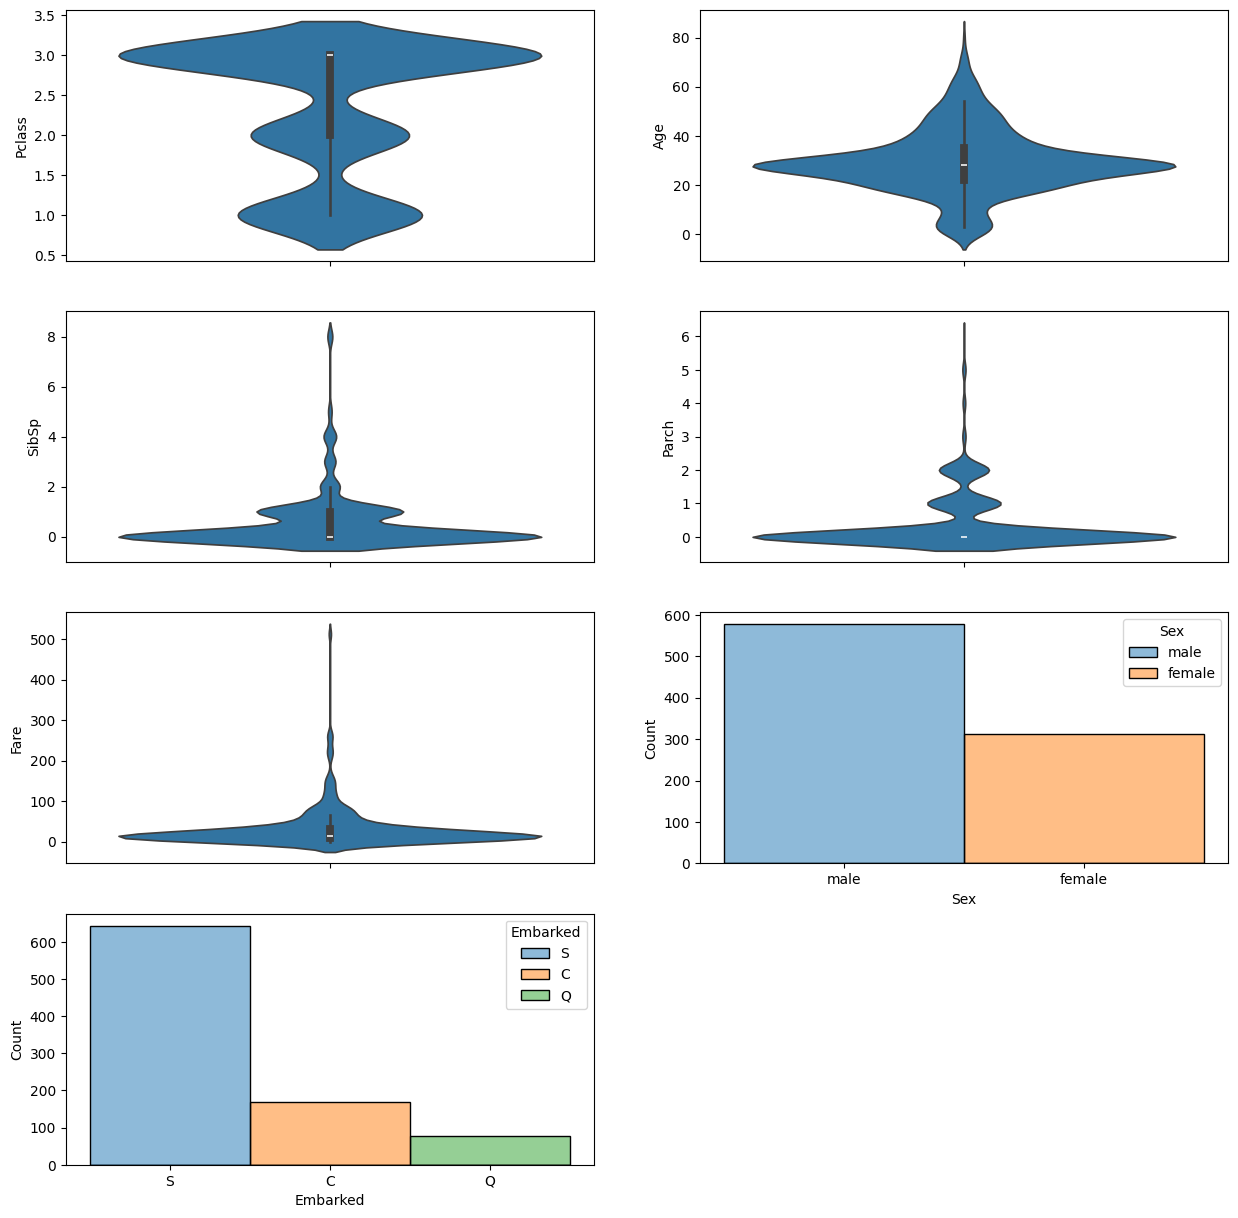

In [258]:
print(dane.describe())

plt.figure(figsize=(15,15))
plt.subplot(4,2,1)
sns.violinplot(data=dane['Pclass'])
plt.subplot(4,2,2)
sns.violinplot(data=dane['Age'])
plt.subplot(4,2,3)
sns.violinplot(data=dane['SibSp'])
plt.subplot(4,2,4)
sns.violinplot(data=dane['Parch'])
plt.subplot(4,2,5)
sns.violinplot(data=dane['Fare'])
plt.subplot(4,2,6)
sns.histplot(data=dane, x="Sex", hue="Sex")
plt.subplot(4,2,7)
sns.histplot(data=dane, x="Embarked", hue="Embarked")

##### Analiza zmienności atrybutów w zależności od przeżycia

       Survived  Pclass    Age  SibSp  Parch   Fare
count    549.00  549.00 549.00 549.00 549.00 549.00
mean       0.00    2.53  30.03   0.55   0.33  22.12
std        0.00    0.74  12.50   1.29   0.82  31.39
min        0.00    1.00   1.00   0.00   0.00   0.00
25%        0.00    2.00  23.00   0.00   0.00   7.85
50%        0.00    3.00  28.00   0.00   0.00  10.50
75%        0.00    3.00  35.00   1.00   0.00  26.00
max        0.00    3.00  74.00   8.00   6.00 263.00
       Survived  Pclass    Age  SibSp  Parch   Fare
count    340.00  340.00 340.00 340.00 340.00 340.00
mean       1.00    1.96  28.16   0.48   0.47  48.21
std        0.00    0.86  13.67   0.71   0.77  66.75
min        1.00    1.00   0.42   0.00   0.00   0.00
25%        1.00    1.00  21.00   0.00   0.00  12.44
50%        1.00    2.00  28.00   0.00   0.00  26.00
75%        1.00    3.00  35.00   1.00   1.00  56.95
max        1.00    3.00  80.00   4.00   5.00 512.33


Text(0.5, 1.0, 'Survived = 1')

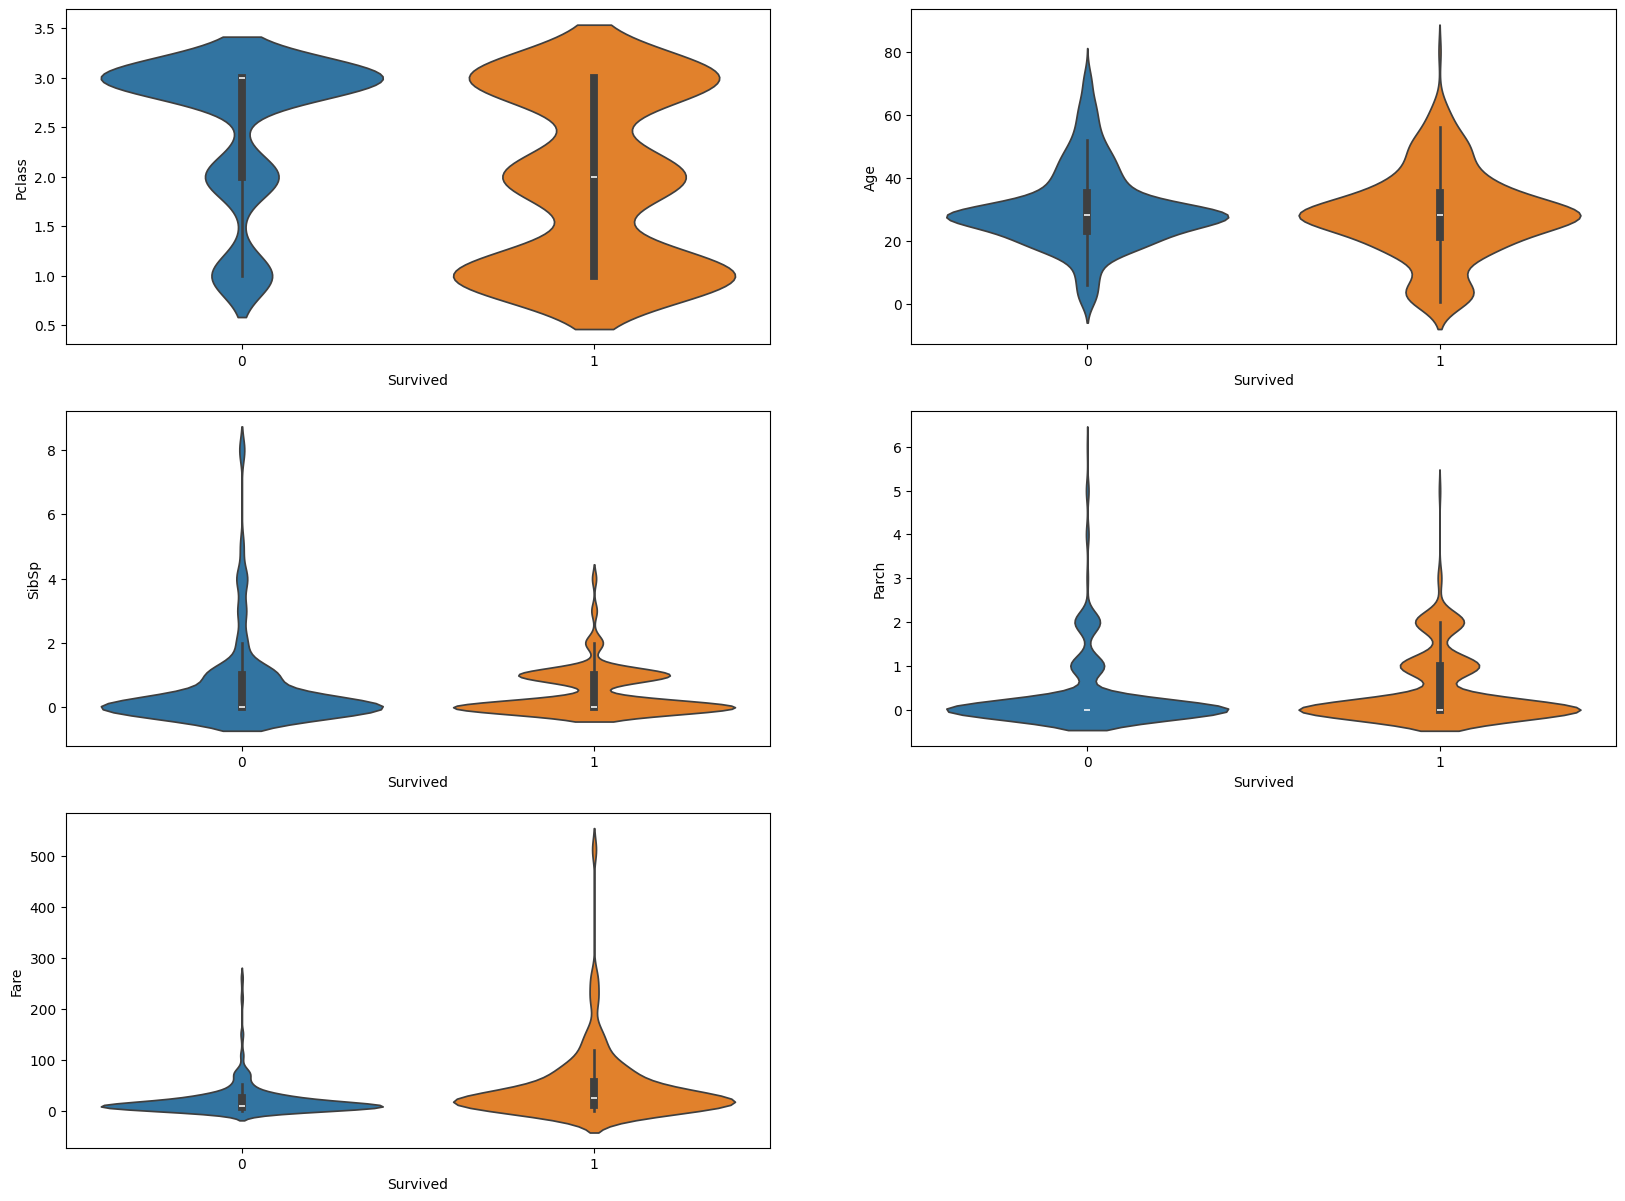

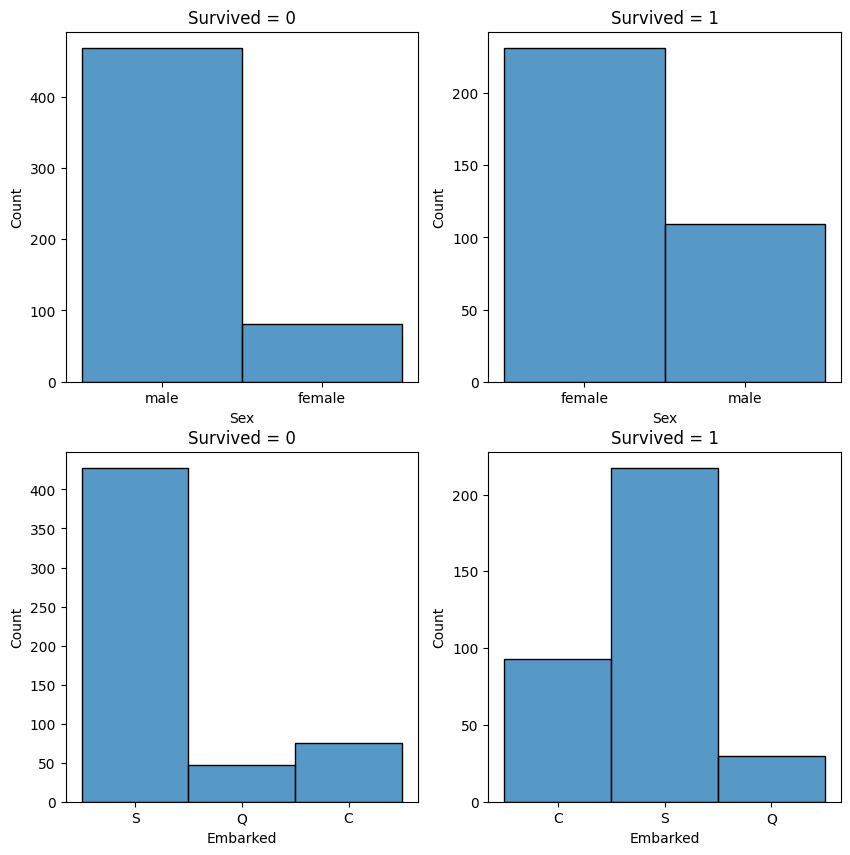

In [282]:
print(dane[dane['Survived'] == 0].describe())
print(dane[dane['Survived'] == 1].describe())
plt.figure(figsize= (20,20))
plt.subplot(4, 2, 1)
sns.violinplot(x = 'Survived', y = 'Pclass', data=dane, legend=False, hue = 'Survived')
plt.subplot(4, 2, 2)
sns.violinplot(x = 'Survived', y = 'Age', data=dane, legend=False, hue = 'Survived')
plt.subplot(4, 2, 3)
sns.violinplot(x = 'Survived', y = 'SibSp', data=dane, legend=False, hue = 'Survived')
plt.subplot(4, 2, 4)
sns.violinplot(x = 'Survived', y = 'Parch', data=dane, legend=False, hue = 'Survived')
plt.subplot(4, 2, 5)
sns.violinplot(x = 'Survived', y = 'Fare', data=dane, legend=False, hue = 'Survived')
plt.figure(figsize= (10,10))
plt.subplot(2, 2, 1)
sns.histplot(data=dane[dane['Survived'] == 0], x="Sex").set_title("Survived = 0")
plt.subplot(2, 2, 2)
sns.histplot(data=dane[dane['Survived'] == 1], x="Sex").set_title("Survived = 1")
plt.subplot(2, 2, 3)
sns.histplot(data=dane[dane['Survived'] == 0], x="Embarked").set_title("Survived = 0")
plt.subplot(2, 2, 4)
sns.histplot(data=dane[dane['Survived'] == 1], x="Embarked").set_title("Survived = 1")


##### Wykres punktowy

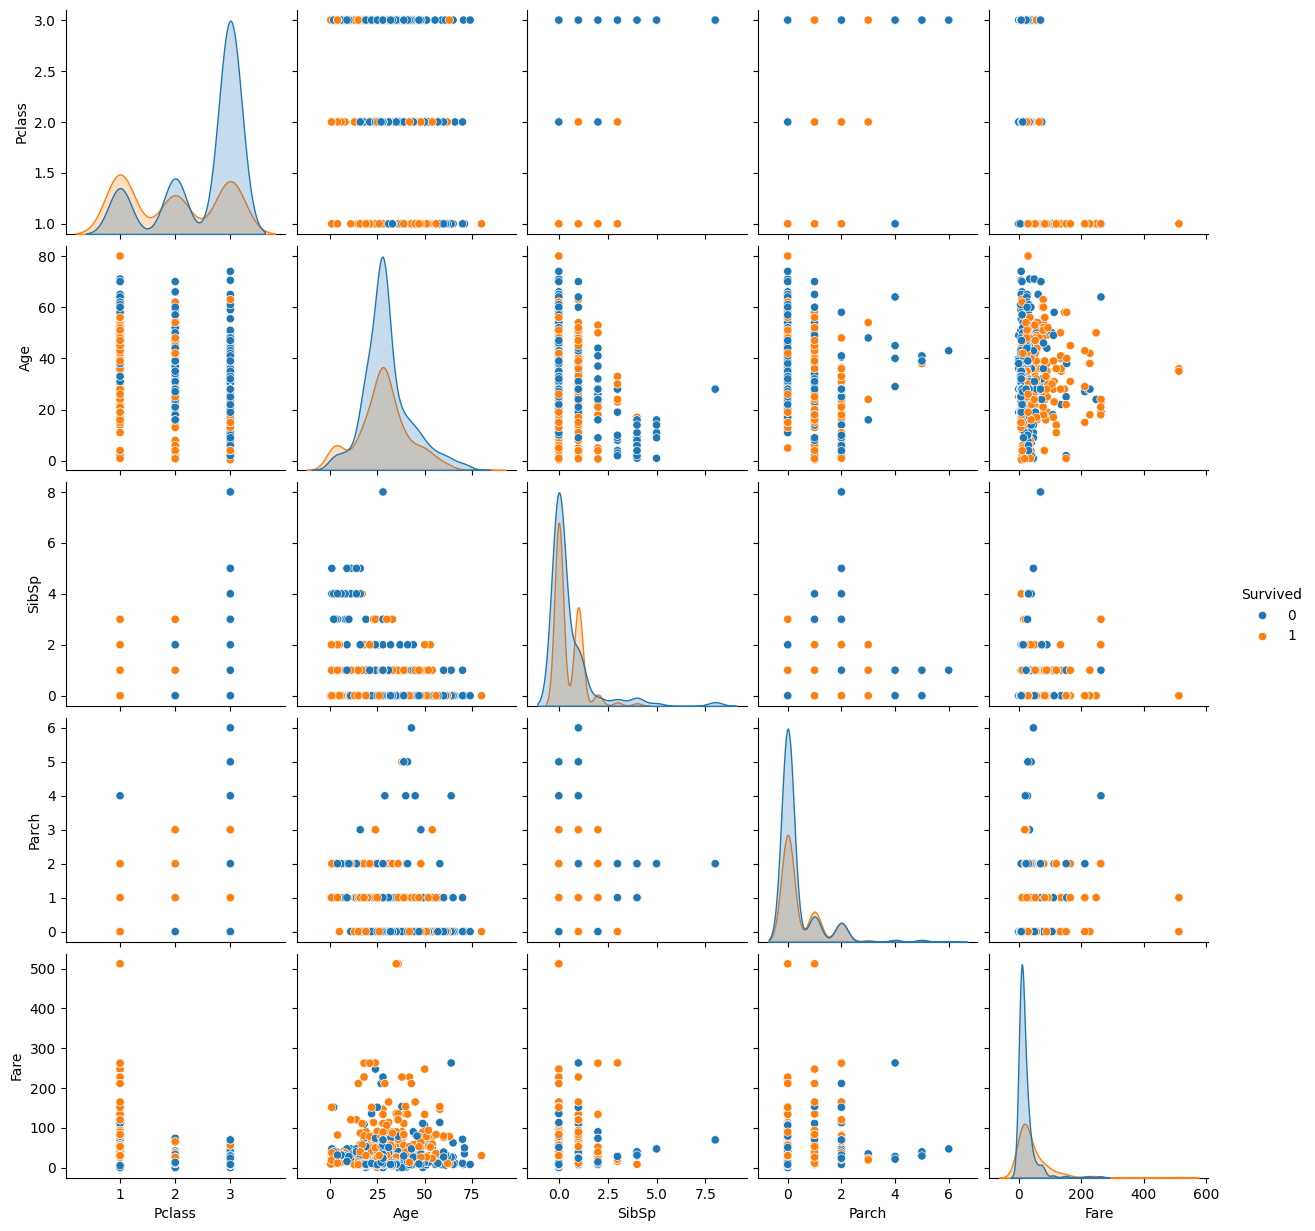

In [283]:
sns.pairplot(dane, kind = 'scatter', hue = "Survived")

##### Korelacja

          Survived  Pclass   Age  SibSp  Parch  Fare
Survived      1.00   -0.34 -0.07  -0.03   0.08  0.26
Pclass       -0.34    1.00 -0.34   0.08   0.02 -0.55
Age          -0.07   -0.34  1.00  -0.23  -0.17  0.09
SibSp        -0.03    0.08 -0.23   1.00   0.41  0.16
Parch         0.08    0.02 -0.17   0.41   1.00  0.22
Fare          0.26   -0.55  0.09   0.16   0.22  1.00


<Axes: >

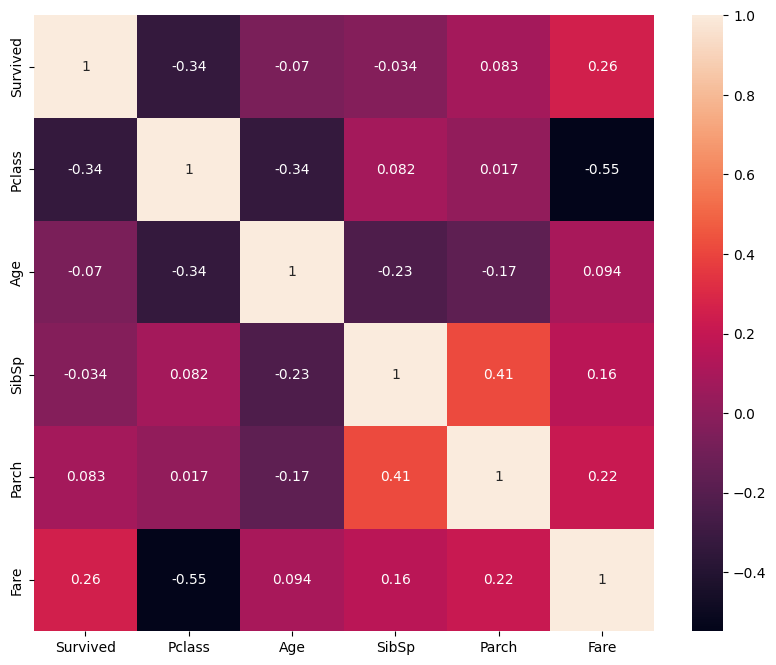

In [296]:
kor = dane.loc[:, np.logical_and(dane.columns != "Sex", dane.columns != "Embarked")].corr()
print(kor)
plt.figure(figsize=(10,8), dpi =100)
sns.heatmap(kor, annot=kor)